# **A Geospatial Assessment of Burn Severity and Social Vulnerability in the 2025 LA Wildfires**

*Author: Melannie Moreno Rolón* 

*Date published: 12/12/2025*

You can access the link to the GitHub Repository for more information about this project [here](https://github.com/mmorenorolon/eaton-palisades-eji-false-imagery.git). More detailed content and supporting materials are available there.

## **Background**:

![Post-fire landscape in Los Angeles County following the Eaton and Palisades wildfires in early 2025, illustrating burned hillslopes. Source: USDA Forest Service, Rocky Mountain Research Station; Saunders, L. (2025), “Science supports Los Angeles wildfires’ aftermath."](attachment:image.png)

In early 2025, wildfires burned across Southern California, including the Eaton and Palisades fires in Los Angeles County. This event forced communities to evacuate and caused widespread damage to homes, infrastructure, and natural landscapes. While firefighting efforts eventually contained the flames, the risks associated with these events did not end with fire suppression. According to the USDA Forest Service, burned hillslopes left behind by these fires became highly vulnerable to secondary hazards such as flash flooding, erosion, and mudslides during subsequent rain events. Scientists from the USDA Forest Service’s Rocky Mountain Research Station and interagency response teams deployed post-fire assessment tools to identify areas most at risk and to support mitigation efforts aimed at protecting downstream communities and critical infrastructure (Saunders, 2025).

These post-fire risks highlight the importance of understanding not only where wildfires occur, but also how their impacts intersect with the landscapes and communities affected by them. In response to this need, I examined the extent of the damage and social vulnerability wrought by the Eaton and Palisades fires. First, I used Landsat 8 false-color imagery to visualize burn scars by assigning infrared bands to visible colors and allow burn severity and the spatial extent of damage to be clearly identified. Second, my analysis integrates Environmental Justice Index (EJI) data with official fire perimeters to explore the social dimensions of wildfire impacts. Together, these approaches demonstrate how geospatial data science can be used to assess both the physical effects of wildfires and the uneven social conditions that shape community vulnerability and recovery.
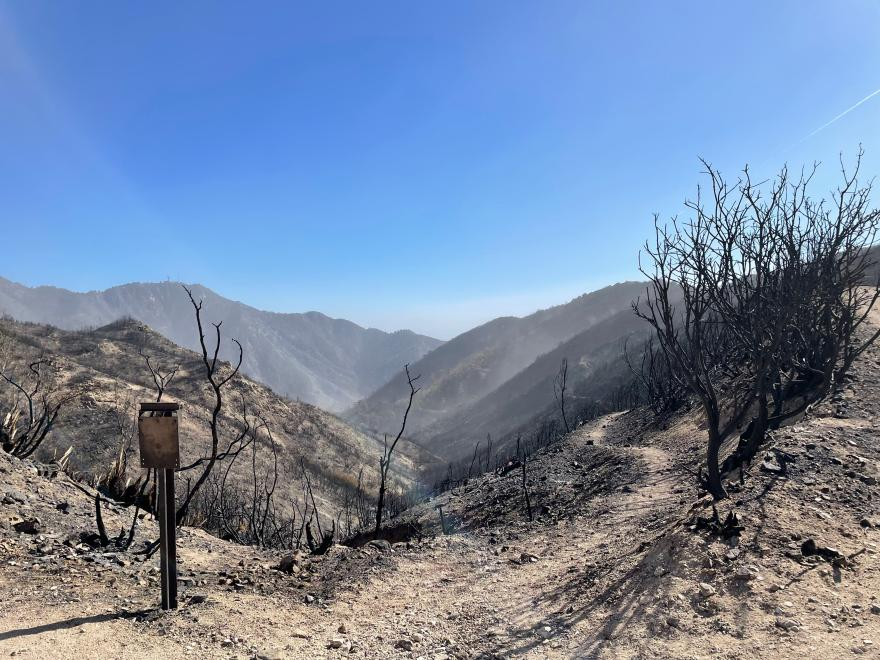

## **Highlights**

- **Fire Perimeter Processing**

Used `geopandas` to import, clean, reproject, and merge Eaton and Palisades fire perimeter shapefiles. Confirmed consistency in CRS and prepared the data layers for spatial analysis and satellite overlay.

- **Satellite Imagery Handling & False-Color Composites**

Loaded Landsat 8 surface reflectance data with `xarray`, restored missing CRS information using `rioxarray`. I created both true-color (RGB) and false-color (SWIR–NIR–Red) composites using `matplotlib` to highlight burn scars and vegetation loss.

- **Environmental Justice Analysis**

Imported California Environmental Justice Index (EJI) data to perform spatial joins and clip operations with `geopandas`. I used `pandas` to isolate for the social-vulnerability variable of interest (`E_DISABL`) which represents the percent of residents with a disability.

- **Geospatial Visualization for Community Impact Assessment**

Combined the fire perimeters, satellite imagery, and EJI demographic data into comparative maps using `matplotlib` and `contextily` to reveal how wildfire footprints intersect with socially vulnerable communities in Los Angeles County.

## **About the Data: Datasets Description**

#### **Landsat Data**:
The NetCDF dataset `landsat8-2025-02-23-palisades-eaton.nc` contains atmospherically corrected surface reflectance data from the Landsat 8 satellite, published on February 23, 2025 through the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2). It includes key spectral bands (red, green, blue, near-infrared, and shortwave infrared) clipped to the perimeters of the Eaton and Palisades Fires in Los Angeles County. The dataset stores geospatial metadata in the `spatial_ref` variable. With a spatial resolution of 30 meters, this dataset supports the creation of true color and false color composites to assess vegetation health, burn severity and the extent of fire scars. Date Accessed: 11/19/2025

#### **Fire Perimeter Data**:
The Palisades and Eaton Dissolved Fire Perimeters (2025) dataset, published on January 21, 2025 by the County of Los Angeles, provides dissolved boundary polygons for the Eaton and Palisades Fires. Derived from the NIFC FIRIS fire service, which originally contained daily perimeter snapshots, the boundaries were merged to create a single burn perimeter for each fire. One Eaton record (mission 2025-CALAC-009087) was excluded because buffered “destroyed” points did not reliably represent burned areas. The dataset is hosted on [ArcGIS Hub](https://hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about) and includes geospatial layers for both fire perimeters, which supports wildfire impact analysis, mapping and environmental monitoring. Date Accessed: 11/19/2025

#### **Environmental Justice Index Data**:
The [Environmental Justice Index](https://www.atsdr.cdc.gov/place-health/php/eji/eji-data-download.html) (EJI) dataset provides census-tract-level indicators that capture the social and demographic conditions shaping a community’s ability to prepare for, respond to, and recover from environmental hazards. The dataset includes variables related to socioeconomic status, housing and transportation, health vulnerability, and population characteristics. For this analysis, we downloaded the EJI data for California in 2024. This analysis also focuses on the variable `E_DISABL`, which represents the percentage of residents with a disability in each census tract. Date Accessed: 11/21/2025

### **Import Libraries and Data**

I first imported the libraries and loaded the dataframes required to perform the analysis.

In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.patches as mpatches

In this first step, we loaded the Python packages used throughout the notebook. These libraries provide tools for working with geospatial raster and vector data, plotting imagery, handling coordinate reference systems (CRS), and managing arrays. This foundation is necessary before reading the fire perimeter shapefiles and Landsat NetCDF imagery.

###  **Fire Perimeter Data Exploration**

#### Loading the Eaton Fire Perimeter

We begin by loading the Eaton Fire perimeter shapefile. This allows us to inspect the geometry structure, attribute fields, and CRS. Understanding the perimeter data ensures that it will align properly with the Landsat imagery later in the notebook.

In [2]:
# Read in Eaton fire perimeter data
eaton_fire = gpd.read_file(os.path.join('data','Eaton_Perimeter_20250121','Eaton_Perimeter_20250121.shp'))

# View the first five rows of the `eaton_fire` geodataframe
eaton_fire.head()

OBJECTID            type    Shape__Are  Shape__Len  \
0         1  Heat Perimeter   2206.265625  270.199719   
1         2  Heat Perimeter  20710.207031  839.204218   
2         3  Heat Perimeter   3639.238281  250.304502   
3         4  Heat Perimeter   1464.550781  148.106792   
4         5  Heat Perimeter   4132.753906  247.960744   

                                            geometry  
0  POLYGON ((-13146936.686 4051222.067, -13146932...  
1  POLYGON ((-13150835.463 4052713.929, -13150831...  
2  POLYGON ((-13153094.697 4053057.596, -13153113...  
3  POLYGON ((-13145097.740 4053118.235, -13145100...  
4  POLYGON ((-13153131.126 4053196.882, -13153131...

#### Loading the Palisades Fire Perimeter 
Next, we read in the Palisades fire perimeter data.

In [3]:
# Read in Palisades fire perimeter data
palis_fire = gpd.read_file(os.path.join('data','Palisades_Perimeter_20250121', 'Palisades_Perimeter_20250121.shp'))

# View the first five rows of the palis_fire perimeter geodataframe
palis_fire.head()

OBJECTID            type    Shape__Are   Shape__Len  \
0         1  Heat Perimeter   1182.082031   267.101144   
1         2  Heat Perimeter   2222.488281   185.498783   
2         3  Heat Perimeter     21.011719    22.412814   
3         4  Heat Perimeter    214.992188    76.639180   
4         5  Heat Perimeter  44203.453125  1569.259764   

                                            geometry  
0  POLYGON ((-13193543.302 4032913.077, -13193543...  
1  POLYGON ((-13193524.155 4033067.953, -13193524...  
2  POLYGON ((-13193598.085 4033158.222, -13193598...  
3  POLYGON ((-13193654.249 4033146.033, -13193656...  
4  POLYGON ((-13194209.580 4033236.320, -13194209...

### Merging Eaton and Palisades Perimeters
Because both perimeter shapefiles share the same CRS and attribute structure, we can safely merge them into one GeoDataFrame.  
This combined dataset (`fires`) streamlines visualization and overlay operations later in the notebook. The following code verifies that the CRS's are the same and share the same columns. In addition, we add a new column to be able to differentiate within our merged geodataframe which geometries correspond to the Palisades and Eaton fire perimeters.


In [4]:
# Check that both geodataframes share the same CRS
assert eaton_fire.crs == palis_fire.crs

# Add a new column to identify each fire's geometries within the dataframe
eaton_fire['fire_name'] = 'Eaton'
palis_fire['fire_name'] = 'Palisades'

# Concatenate both geodataframes
fires = gpd.GeoDataFrame(pd.concat([eaton_fire, palis_fire], ignore_index= True))

# View the first five rows of `fires`
fires.head()

OBJECTID            type    Shape__Are  Shape__Len  \
0         1  Heat Perimeter   2206.265625  270.199719   
1         2  Heat Perimeter  20710.207031  839.204218   
2         3  Heat Perimeter   3639.238281  250.304502   
3         4  Heat Perimeter   1464.550781  148.106792   
4         5  Heat Perimeter   4132.753906  247.960744   

                                            geometry fire_name  
0  POLYGON ((-13146936.686 4051222.067, -13146932...     Eaton  
1  POLYGON ((-13150835.463 4052713.929, -13150831...     Eaton  
2  POLYGON ((-13153094.697 4053057.596, -13153113...     Eaton  
3  POLYGON ((-13145097.740 4053118.235, -13145100...     Eaton  
4  POLYGON ((-13153131.126 4053196.882, -13153131...     Eaton

### Cleaning Column Names  
To make the dataset easier to work with, we standardize column names by converting them to lowercase and renaming fields such as `shape_are` to`area` and `shape_len` to `length`. Clean column names reduce ambiguity and improve readability in subsequent analyses.


In [ ]:
# Simplify the geodataframe columns
fires.columns = (
    fires.columns
    .str.strip()          # Remove leading or trailing spaces
    .str.lower()          # Convert to lowercase
    .str.replace("__", "_")  # Replace double underscores with single
)

# View the simplified geodataframe columns
fires.columns

Index(['objectid', 'type', 'shape_are', 'shape_len', 'geometry'], dtype='object')

After cleaning the column names, I renamed `shape_are` and `shape_len` to `area` and `length`, respectively, to improve readability and ensure the column names were more easily interpretable throughout the analysis.

In [7]:
# Rename the `shape_are` and `shape_len` columns
fires= fires.rename(columns={
    "shape_are": "area",
    "shape_len": "length"
})

# View the dataframe with the renamed columns
fires.columns

Index(['objectid', 'type', 'area', 'length', 'geometry'], dtype='object')

Now that the fire perimeter data have been imported, merged, and cleaned, we can proceed to preprocess the Landsat NetCDF dataset.

### **NetCDF data import and exploration**

#### Loading the Landsat 8 Bands

After processing the fire perimeter data, I proceeded to load the individual spectral bands from the Landsat 8 dataset. Each band represents reflectance in a different portion of the electromagnetic spectrum. Because false color imagery relies on assigning SWIR, NIR, and Red bands to visible colors, loading these bands correctly is essential for constructing the final composite.

In [5]:
# Read in Landsat 8 data
landsat8 = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')

Calling `.info()` provides an overview of all available variables (such as red, green, blue, NIR, and SWIR bands), along with their shapes, units, and stored metadata. This step ensures we understand how the dataset is stored and which variables are required for color composite creation.

In [7]:
# Obtain detailed information about variables and data types
landsat8.info()          

xarray.Dataset {
dimensions:
	y = 1418 ;
	x = 2742 ;

variables:
	float64 y(y) ;
		y:units = metre ;
		y:resolution = -30.0 ;
		y:crs = EPSG:32611 ;
		y:axis = Y ;
		y:long_name = y coordinate of projection ;
		y:standard_name = projection_y_coordinate ;
	float64 x(x) ;
		x:units = metre ;
		x:resolution = 30.0 ;
		x:crs = EPSG:32611 ;
		x:axis = X ;
		x:long_name = x coordinate of projection ;
		x:standard_name = projection_x_coordinate ;
	datetime64[ns] time() ;
	float32 red(y, x) ;
		red:grid_mapping = spatial_ref ;
	float32 green(y, x) ;
		green:grid_mapping = spatial_ref ;
	float32 blue(y, x) ;
		blue:grid_mapping = spatial_ref ;
	float32 nir08(y, x) ;
		nir08:grid_mapping = spatial_ref ;
	float32 swir22(y, x) ;
		swir22:grid_mapping = spatial_ref ;
	int64 spatial_ref() ;
		spatial_ref:crs_wkt = PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["

The `keys()` method allows us to view the list of variable names in the landsat8 geodataframe. 

In [8]:
# View the list of variable names
landsat8.keys()

KeysView(<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...)

Another way to view just the list of variables without metadata attached to them is using the `list()` method. We did the same for the dataframe's coordinates.

In [20]:
# Check the list of data variables
print(f'List of variables in the Landsat 8 dataset:\n {list(landsat8.data_vars)}') 

# View the list of coordinate variables
print(f'List of coordinate variables in the Landsat 8 dataset: \n {list(landsat8.coords)}')

List of variables in the Landsat 8 dataset:
 ['red', 'green', 'blue', 'nir08', 'swir22', 'spatial_ref']
List of coordinate variables in the Landsat 8 dataset: 
 ['y', 'x', 'time']


#### Quick Band Visualization
Plotting a single band provides an initial visual check and helps confirm that the dataset was read correctly. This is a useful diagnostic step before building composite imagery.


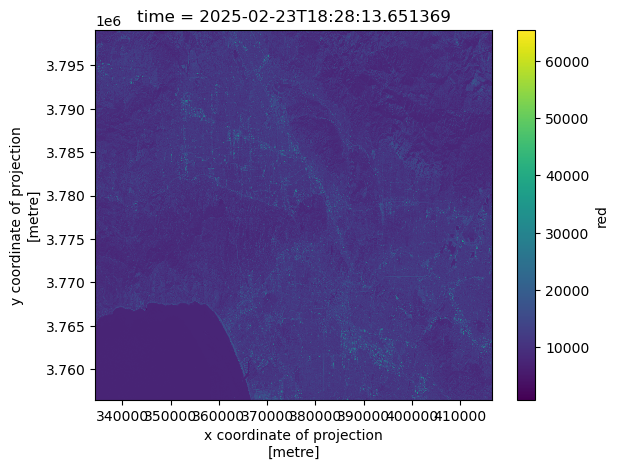

In [6]:
# Quick visualization of the red band of the dataset
landsat8['red'].plot()

#### Summary of Preliminary Exploration for `landsat8`
 The dataset shows that the blue band contains 109 missing values, while the green band has only one; all other variables have no missing data. The spatial dimensions are 1418 y‑coordinates by 2742 x‑coordinates. Band values are stored as integers, whereas the time variable is in datetime format. All measurements are expressed in meters, and the dataset is referenced to CRS 'EPSG:32611'. 

## **Restoring Geospatial Information** 

Before the Landsat imagery can be accurately overlaid with the fire perimeter polygons, it is necessary to ensure that the raster dataset contains complete and correctly defined geospatial reference information. Although the NetCDF file includes a `spatial_ref` variable, the coordinate reference system (CRS) is not automatically recognized. In this section, I restore the missing CRS information to properly align the raster and vector datasets in the subsequent visualizations.

In [25]:
# Print the CRS of `landsat8` with `rio.crs`
print(landsat8.rio.crs)

None


In [26]:
# Print the CRS by using accesing the spatial_ref.crs_wkt attribute of the dataset
landsat8.spatial_ref.crs_wkt

'PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]'

 In the steps above, we confirmed that the landsat8 dataset did not have a recognized CRS and then extracted the WKT-formatted coordinate reference system stored in the `spatial_ref` variable. In the following step, this CRS was written back to the dataset using `.rio.write_crs()`. This process is essential to ensure proper alignment between the raster dataset and the fire perimeter polygons in subsequent analyses.

In [27]:
# Recover the geospatial information and the spatial reference information 
landsat8.rio.write_crs('EPSG:32611', inplace=True)

# Print the CRS of the updated dataset
print(landsat8.rio.crs)

EPSG:32611


## **Creating a True Color Image**

To generate a natural-looking image of the landscape, we combined the red, green, and blue bands.  
Because clouds and bright targets can skew pixel values, we use the `robust=True` parameter to rescale the display range and improve visualization. We also address missing values by replacing NaNs with zeros to avoid rendering warnings.

In [16]:
# Identify which bands have missing values 
landsat8.isnull().sum()

<xarray.Dataset> Size: 32B
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 8B ...
Data variables:
    red          int32 4B 0
    green        int32 4B 1
    blue         int32 4B 109
    nir08        int32 4B 0
    swir22       int32 4B 0
    spatial_ref  int32 4B 0

The green and blue bands have missing values.

In [28]:
# Substitute any missing values in the dataset with zeroes
landsat8_filled = landsat8.fillna(0)

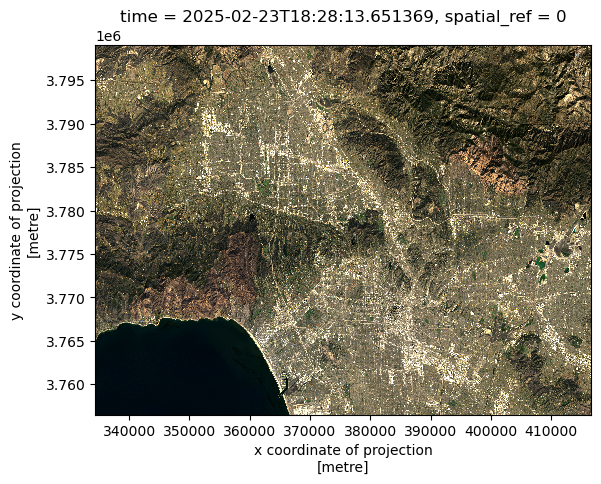

In [29]:
# Create a true color image without warnings
landsat8_filled[['red','green','blue']].to_array().plot.imshow(robust=True)

### True Color Image Generation Takeaways
Because clouds are extremely bright, they can stretch the display scale, causing non-cloud pixels to be compressed into a narrow range and making the image appear nearly blank. Setting the `robust=True` parameter instructs `xarray` to ignore extreme outliers, which resolves this issue and allows surface features to become visible. To further assess data quality, I used `landsat8.isnull().sum()` to identify missing values across spectral bands and revealed that there were NaN values in the green and blue bands. These missing values were addressed by applying `fillna(0)` prior to generating the true-color image.

While the true-color composite provides a realistic view of the landscape, it can still obscure burn scars and vegetation stress, particularly in complex post-fire environments. For this reason, we create a false-color composite, which leverages infrared bands to more effectively distinguish burned areas and variations in vegetation health.

## **Creating a False Color Composite**

To highlight burn scars and vegetation health, we combine three Landsat bands into a false color image:

- **SWIR** → **Red channel**
- **NIR** → **Green channel**
- **Red** → **Blue channel**

This band arrangement enhances the visibility of burned regions and stressed vegetation. Therefore, this visualization will make it easier to interpret fire impacts across the Palisades and Eaton areas.

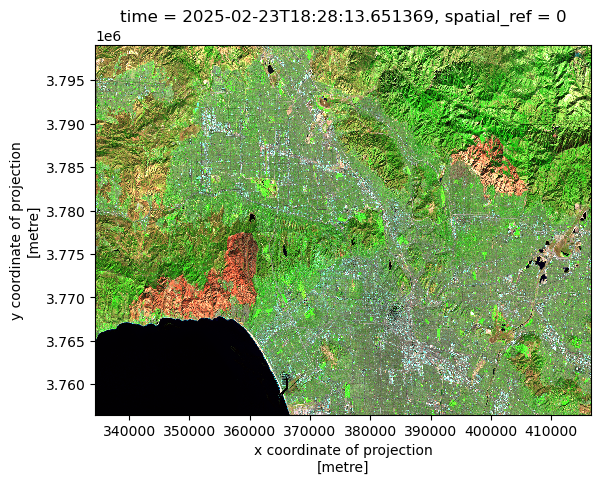

In [14]:
# Plot the short-wave infrared (swir22), near-infrared, and red variables (in that order)
landsat8_filled[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True)

With the false-color composite successfully generated, the next step is to overlay the Eaton and Palisades fire perimeters using the boundary data processed earlier. This allows the spatial extent of the burn scars to be directly compared with the official fire boundaries.

### **Reprojecting Raster and Vector Data**
The Landsat imagery and fire perimeter shapefiles may use different coordinate reference systems (CRS). To properly overlay perimeter polygons on the raster data, we reproject both datasets into a common CRS. This ensures that pixel locations align with fire boundaries on the map.


In [34]:
# Reproject the `fires` polygons to the landsat dataset
fires = fires.to_crs(landsat8_filled.rio.crs)

# Check that the CRS's match after reprojection
print(f'CRS verification after reprojection:\n {fires.crs == landsat8.rio.crs}')

# View the boundary coordinates of the fires 
print(f'Total bounds:\n {fires.total_bounds}')

CRS verification after reprojection:
 True
Total bounds:
 [ 344406.73232733 3766517.4675391   406646.84925345 3789057.23010932]


## Mapping Fire Perimeters with a False Color Composite
In this final visualization, we overlay the Eaton and Palisades fire boundaries on the false color image.  
This map reveals which areas exhibit increased SWIR reflectance, which is a strong indicator of recent burns, and confirms alignment with official fire perimeters. Text annotations help distinguish each fire footprint.


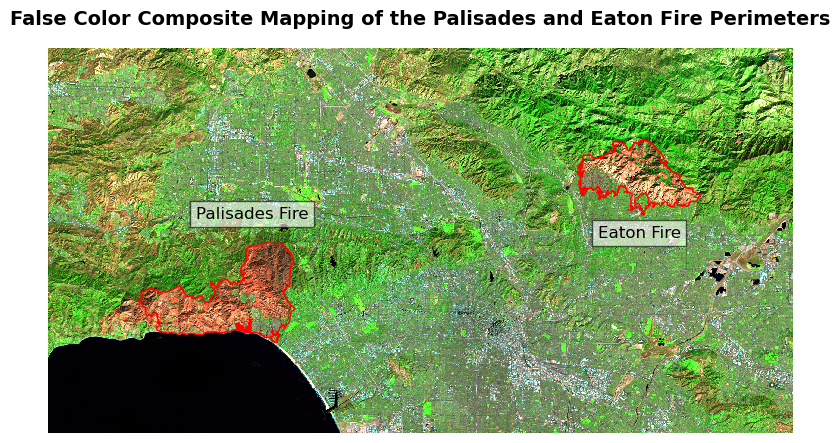

<Figure size 640x480 with 0 Axes>

In [35]:
# Create empty plot
fig, ax = plt.subplots(figsize=(11,5))
ax.axis('off')

# Show the shortwave infrared/near-infrared/red false color image together with both fire perimeters
landsat8_filled[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True, ax = ax)
fires.plot(ax=ax, 
           legend=True,
           color = 'none',
           edgecolor='red')

# Add a title
ax.set_title("False Color Composite Mapping of the Palisades and Eaton Fire Perimeters", fontsize=14, fontweight='bold')

# Add text annotation for the Eaton Fire
ax.text(0.85, 0.5, "Eaton Fire",
        transform=ax.transAxes,  # relative to axes (0–1)
        ha="right", va="bottom",
        fontsize=12, bbox=dict(facecolor="white", alpha=0.6))

# Add text annotation for the Palisades Fire
ax.text(0.35, 0.55, "Palisades Fire",
        transform=ax.transAxes,  # relative to axes (0–1)
        ha="right", va="bottom",
        fontsize=12, bbox=dict(facecolor="white", alpha=0.6))

# Display plot
plt.show()
plt.tight_layout()

**More About the Use of False Color Imagery in this Figure**

The image above used the shortwave infrared (SWIR), near-infrared (NIR), and red band combination, which highlights the visibility of burned areas and stress on vegetation. In this false color scheme, healthy vegetation appears in bright green
In this combination, shortwave infrared (SWIR) is assigned to the red display channel, near-infrared (NIR) to green, and red light to blue. Burn scars appear in deep red tones, while SWIR reflectance increases after vegetation burns due to the loss of water content and exposure of burned soil. Vegetation reflects strongly in the NIR, which is mapped to the green channel in this composite, while Urban areas and developed land appear in shades of cyan or gray. Water appears very dark or black because both SWIR and NIR are almost completely absorbed by water. These spectral relationships allow the burned areas from the Palisades and Eaton fires to stand out strongly against the surrounding landscape. The fire perimeters (shown as transparent red polygons) align with the regions of intense SWIR reflectance. This map confirms the extent of the burn scars captured by Landsat.

While false-color imagery is effective for identifying the spatial extent and severity of wildfire damage, it captures only the physical impacts on the landscape. To fully understand the consequences of the Eaton and Palisades fires, it is also necessary to examine how these burned areas intersect with nearby communities and their social characteristics. In the next section, the analysis shifts from satellite-based burn mapping to a social vulnerability perspective by integrating Environmental Justice Index (EJI) data with the fire perimeters to explore how wildfire exposure overlaps with populations that may face additional challenges during response and recovery.

## **Social dimensions of the Eaton and Palisades Fires**

Wildfires do not impact all communities equally. Beyond the physical footprint of a burn scar, the social and demographic characteristics of nearby neighborhoods play a crucial role in shaping how residents experience, respond to, and recover from wildfire events. In this section, I explore the social dimensions of the Eaton and Palisades Fires by integrating census-tract–level indicators from the Environmental Justice Index (EJI) with each fire’s geographic perimeter.

### Importing EJI Data

First, the data were imported and the Palisades and Eaton fire polygons were reprojected to a common coordinate reference system (CRS) before performing the spatial join.

In [36]:
# Read in the EJI dataset
ca_eji_fp = os.path.join('data','EJI_2024_California_GDB/EJI_2024_California/EJI_2024_California.gdb')
ca_eji = gpd.read_file(ca_eji_fp)

In [38]:
# Reproject all datasets to the same crs
palis_fire = palis_fire.to_crs(ca_eji.crs)
eaton_fire = eaton_fire.to_crs(ca_eji.crs)

The purpose of the spatial join is to identify which Environmental Justice Index (EJI) census tracts intersect the Eaton and Palisades fire perimeters. By retaining only the census tracts that spatially overlap the fire boundaries, the spatial join links geographic exposure to wildfire with tract-level social and demographic attributes. This step allows the analysis to focus specifically on communities that were directly affected by the fires.

In [39]:
# Get the EJI tracts intersecting the palisades fire perimeter
eji_palisades_join = gpd.sjoin(ca_eji, palis_fire, how='inner', predicate='intersects')

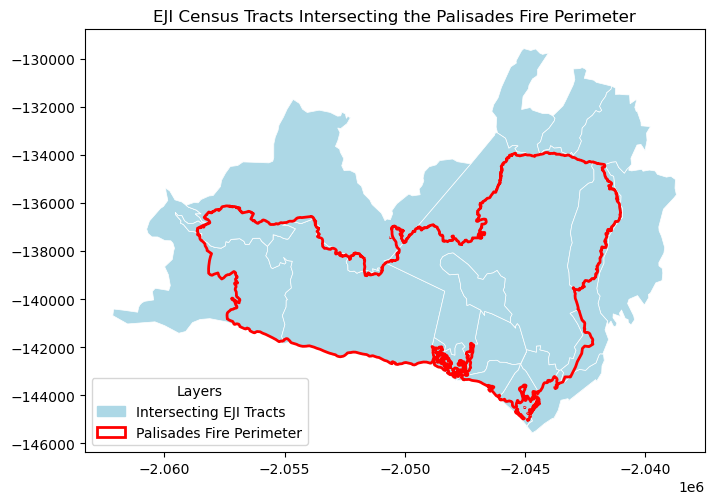

In [41]:
# Create an empty figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the spatially joined polygon
eji_palisades_join.plot(ax=ax, 
                        color="lightblue", 
                        edgecolor="white", 
                        linewidth=0.5,
                        label="Intersecting EJI Tracts")

# Plot the Palisades fire boundaries
palis_fire.boundary.plot(ax=ax,
                         color="red",
                         linewidth=2,
                         label="Palisades Fire Perimeter")

# Create a legend patch for EJI census tracts intersecting the fire perimeter
eji_patch = mpatches.Patch(
    color="lightblue", 
    label="Intersecting EJI Tracts")

# Create a legend patch for the Palisades fire perimeter
palis_patch = mpatches.Patch(
    facecolor="none", 
    edgecolor="red",
    linewidth=2,
    label="Palisades Fire Perimeter")

# Add title and legend
ax.set_title("EJI Census Tracts Intersecting the Palisades Fire Perimeter")
ax.legend(handles=[eji_patch, palis_patch], title="Layers", loc='lower left')
plt.show()


In the case of the Palisades Fire, several entire census tracts fall completely inside the fire perimeter, while others intersect only along the edges. This means the fire footprint is large relative to the size of nearby census tracts, covering substantial portions of the local communities. Unlike many wildfires that only clip small parts of multiple tracts, the Palisades Fire burned through whole tracts, indicating that the impacted population and built environment may span multiple full census units.

The same process was repeated for the Eaton fire perimeter, resulting in a dataset of EJI census tracts that intersect the fire boundary.

In [42]:
# Get the EJI tracts intersecting the eaton fire perimeter
eji_eaton_join = gpd.sjoin(ca_eji, eaton_fire, how='inner', predicate='intersects')

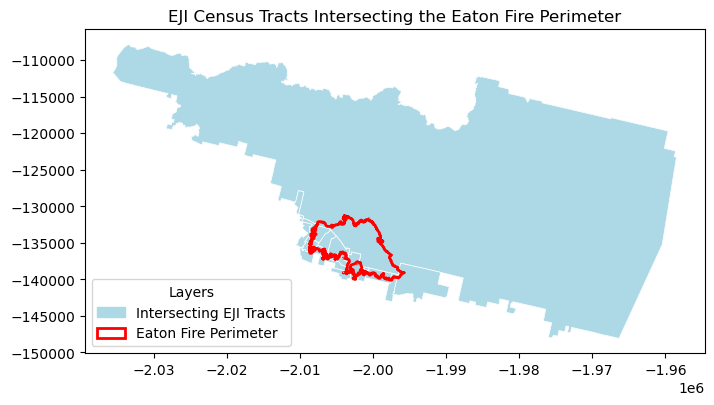

In [43]:
# Create empty figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the spatially joined polygon
eji_eaton_join.plot(
    ax=ax, 
    color="lightblue", 
    edgecolor="white", 
    linewidth=0.5,
    label="Intersecting EJI Tracts"
)

# Plot the Eaton fire boundaries
eaton_fire.boundary.plot(
    ax=ax,
    color="red",
    linewidth=2,
    label="Eaton Fire Perimeter"
)

# Create a legend patch for EJI census tracts intersecting the fire perimeter
eji_patch = mpatches.Patch(
    color="lightblue", 
    label="Intersecting EJI Tracts")

# Create a legend patch for the Eaton fire perimeter
eaton_patch = mpatches.Patch(
    facecolor="none", 
    edgecolor="red",
    linewidth=2,
    label="Eaton Fire Perimeter")

# Add title and legend
ax.set_title("EJI Census Tracts Intersecting the Eaton Fire Perimeter")
ax.legend(handles=[eji_patch, eaton_patch], title="Layers", loc='lower left')
plt.show()

Like the Palisades fire, the Eaton fire boundary is small relative to the size of census tracts. Only a few tracts intersect the fire perimeter, and each tract contains a much larger land area than the fire itself. This illustrates that tract-level EJ metrics aggregate social information across regions far larger than the fire footprint.

#### Clipping Census Tracts to Fire Perimeters

After identifying the census tracts that intersect each fire perimeter using spatial joins, the next step is to refine the analysis by clipping the Environmental Justice Index (EJI) census tracts to the exact boundaries of the Palisades and Eaton fires.

In [44]:
# Clip tracts to the palisades and eaton fire perimeters
eji_palis_clip = gpd.clip(ca_eji, palis_fire)
eji_eaton_clip = gpd.clip(ca_eji, eaton_fire)

#### Difference Between a Spatial Join and Clipping

**Spatial Join `gpd.sjoin()`**

Returns entire census tracts that touch the fire perimeter and the geometry remains unchanged. 

**Clipping `gpd.clip()`**

Returns only the portion of each tract inside the fire perimeter and the geometry is modified.

###  Create Visualization with the Eaton and Palisades Boundaries with the Basemap Using `contextily`

In this visualization, the Eaton and Palisades fire perimeters are overlaid on a basemap using the contextily library to provide geographic context. Displaying both boundaries together helps illustrate their relative locations and extents within Los Angeles County and supports interpretation of subsequent spatial analyses.

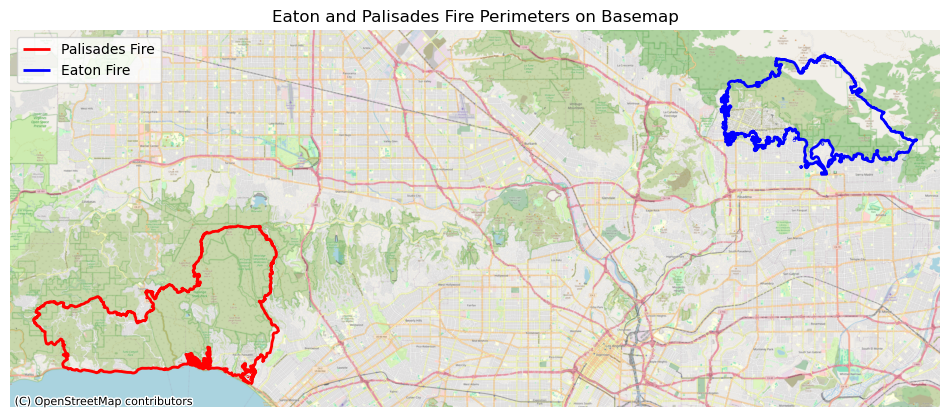

In [ ]:
# Reproject to Web Mercator for basemap
palisades_3857 = palis_fire.to_crs(epsg=3857)
eaton_3857 = eaton_fire.to_crs(epsg=3857)

# Get bounds from each fire
pminx, pminy, pmaxx, pmaxy = palisades_3857.total_bounds
eminx, eminy, emaxx, emaxy = eaton_3857.total_bounds

minx = min(pminx, eminx)
miny = min(pminy, eminy)
maxx = max(pmaxx, emaxx)
maxy = max(pmaxy, emaxy)

# Plot the map, starting with an empty figure
fig, ax = plt.subplots(figsize=(12, 10))

# Set zoom *before* adding basemap
buffer = 2000  # small padding around the fire
ax.set_xlim(minx - buffer, maxx + buffer)
ax.set_ylim(miny - buffer, maxy + buffer)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=13)

# Plot fire boundaries
palisades_3857.boundary.plot(ax=ax, color="red", linewidth=2, label="Palisades Fire")
eaton_3857.boundary.plot(ax=ax, color="blue", linewidth=2, label="Eaton Fire")

# Legend + title
ax.legend(loc = 'upper left')
ax.set_title("Eaton and Palisades Fire Perimeters on Basemap")
ax.axis("off")

plt.show()

The map above displays the locations and extents of the Palisades Fire (outlined in red) and the Eaton Fire (outlined in blue) over a detailed OpenStreetMap basemap of the Los Angeles region. Overlaying the fire boundaries on a familiar street-level basemap allows for clear interpretation of their urban and ecological contexts. This map shows the proximity of the perimeters to major roadways, neighborhoods and parks.

## **From Physical Burn Severity to Social Impact**

After establishing the geographic context of the Eaton and Palisades fires using a basemap and official fire perimeters, I examined social vulnerability within the affected areas. I plotted census tracts symbolized by the percentage of persons with a disability (`E_DISABL`) using the 2024 California Environmental Justice Index dataset. This map highlights the spatial distribution of disability prevalence among census tracts intersecting the Eaton and Palisades fire perimeters. This visualization allows for a clearer understanding of how wildfire exposure overlaps with communities that may face additional challenges during evacuation, emergency response, and recovery. By visualizing this variable at the census-tract level, the map provides critical context for understanding social vulnerability alongside the physical extent of the fires.

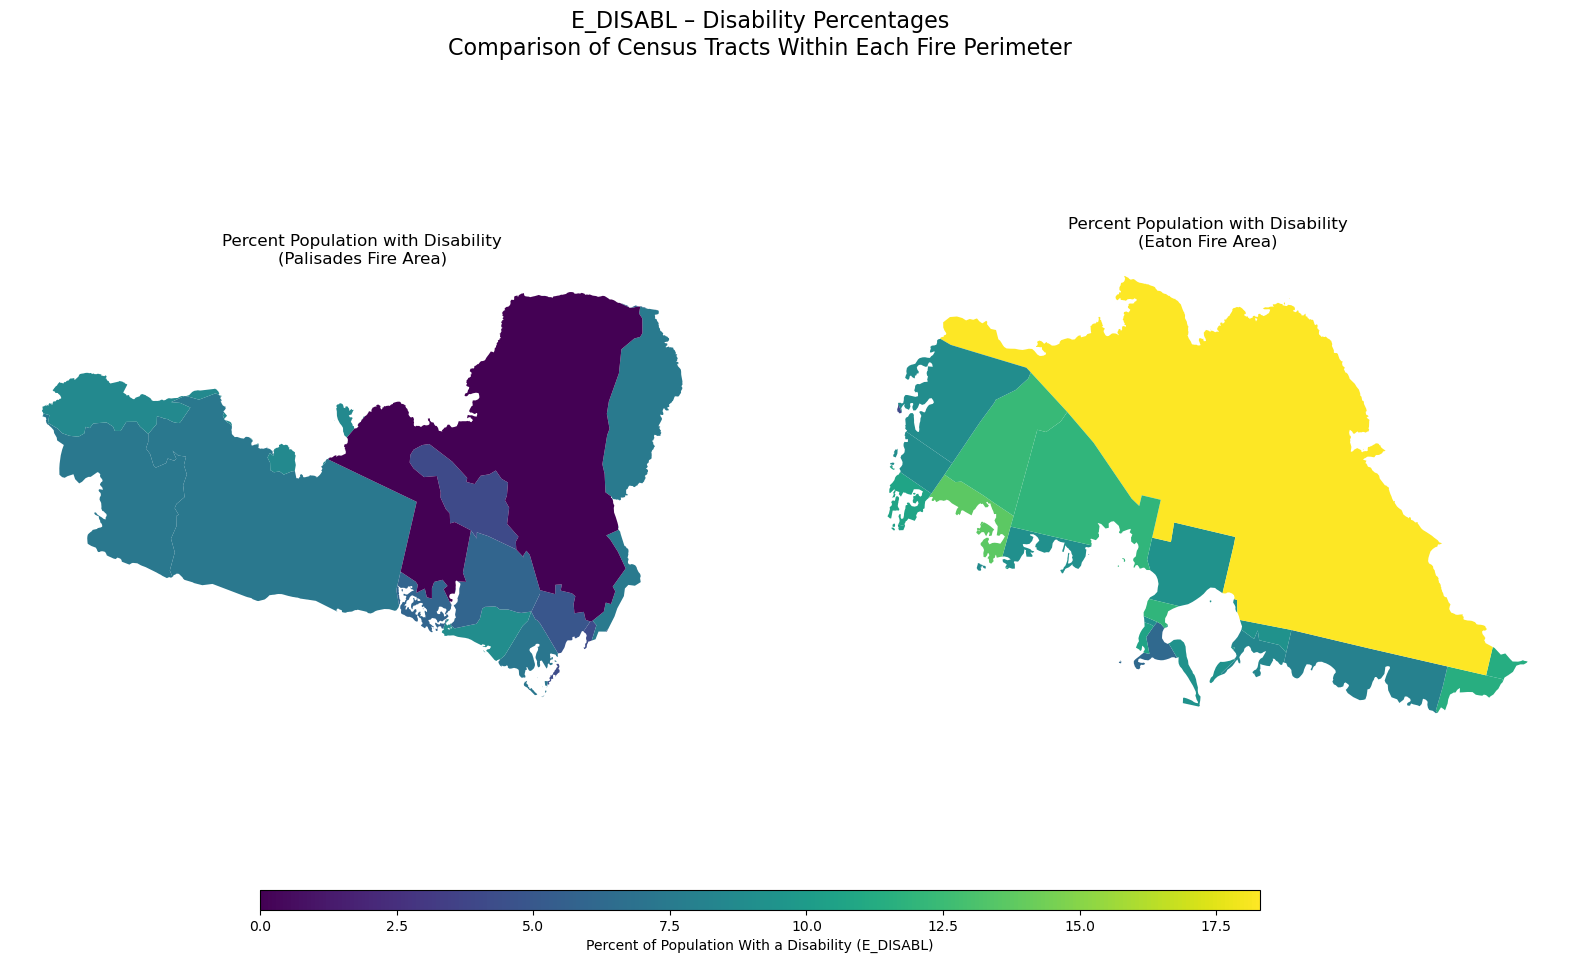

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create empty figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Percentage of persons with a disability
eji_variable = 'E_DISABL'

# Find shared min/max across both datasets
vmin = min(eji_palis_clip[eji_variable].min(),
           eji_eaton_clip[eji_variable].min())

vmax = max(eji_palis_clip[eji_variable].max(),
           eji_eaton_clip[eji_variable].max())

# --- Palisades plot ---
eji_palis_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
    cmap="viridis"
)
ax1.set_title('Percent Population with Disability\n(Palisades Fire Area)')
ax1.axis('off')

# --- Eaton plot ---
eji_eaton_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
    cmap="viridis"
)

#  Add a title for the map
ax2.set_title('Percent Population with Disability\n(Eaton Fire Area)')
ax2.axis('off')

# Create a subtitle
fig.suptitle('E_DISABL – Disability Percentages\nComparison of Census Tracts Within Each Fire Perimeter',
             fontsize=16)

# Shared horizontal colorbar
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02]) 
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Percent of Population With a Disability (E_DISABL)')

plt.show()
plt.tight_layout()

The distribution of `E_DISABL`, or the percent of residents with disabilities, differs noticeably between the census tracts intersecting the Palisades and Eaton fire perimeters. In the Palisades area, disability percentages are generally lower and more varied, with many tracts falling in the lower end of the color scale. In contrast, the Eaton fire area shows consistently higher disability rates across most tracts, with several communities displaying some of the highest values in the comparison. These differences have important implications for wildfire relief and recovery efforts. Communities with higher proportions of residents with disabilities may face additional challenges during evacuation, communication, and rebuilding phases. This means that emergency managers and recovery planners may need to allocate more targeted resources like accessible transportation, medical support, and long-term housing assistance to the Eaton area to ensure equitable and effective wildfire response.

## **References:**

Centers for Disease Control and Prevention and Agency for Toxic Substances Disease Registry. (2024). *Environmental Justice Index [Dataset]*. https://atsdr.cdc.gov/place-health/php/eji/eji-data-download.html

County of Los Angeles. (2025). *Palisades and Eaton dissolved fire perimeters (Version 1.0) [Dataset]*. ArcGIS Hub. https://hub.arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about

Galaz García, C. (2025). *Final project*. EDS - 220 Working with Environmental Datasets. Retrieved from https://meds-eds-220.github.io/MEDS-eds-220-course/assignments/final-project.html

Microsoft. (2025). *landsat8-2025-02-23-palisades-eaton.nc (Version 1.0) [Dataset]*. Microsoft Planetary Computer. https://planetarycomputer.microsoft.com

Saunders, L. (2025) . *Science supports Los Angeles wildfires’ aftermath: Data detects danger — Scientific tools mitigate flash flood and mudslide risks*. USDA Forest Service. https://www.fs.usda.gov/about-agency/features/science-supports-los-angeles-wildfires-aftermath